In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pyreadr
import scanpy as sc
import seaborn as sns
import shap
from tmm import tmm_normalize

In [2]:
def plot_stacked_probs(probs, class_labels=None, sample_labels=None,
                       n_rows=1, figsize=(12, 6), save_path=None, title=None,
                       xlabel='Sample_cluster', sort_by_y=None, ax=None,
                       cmapping=None, renaming=None, width=0.8):
    """
    probs: (n_samples, n_classes) numpy array
    class_labels: list of class names (len = n_classes)
    sample_labels: list of sample names (len = n_samples)
    n_rows: number of rows in the subplot grid
    """
    n_samples, n_classes = probs.shape
    if class_labels is None:
        class_labels = [f"Class {i}" for i in range(n_classes)]
    if sample_labels is None:
        sample_labels = [f"S{i}" for i in range(n_samples)]
    if sort_by_y is not None:
        order = np.argsort(probs[:, sort_by_y])
        probs = probs[order]
        sample_labels = [sample_labels[i] for i in order]

    if renaming is not None:
        class_labels = [renaming.get(cls, cls) for cls in class_labels]
    
    # Compute grid
    if ax is None:
        n_cols = int(np.ceil(n_samples / n_rows))
        fig, axes = plt.subplots(n_rows, 1, figsize=figsize, gridspec_kw={'hspace':0.3},
                                sharey=True)
        if n_rows == 1:
            axes = np.array([axes])
        axes = axes.ravel()
    else:
        axes = np.array([ax])
        fig = plt.gcf()
        n_rows = 1
        n_cols = int(np.ceil(n_samples / n_rows))

    # Colors
    if cmapping is not None:
        colors = [cmapping[cls] for cls in class_labels]
    else:
        cmap = plt.cm.get_cmap("tab20", n_classes)
        colors = [cmap(i) for i in range(n_classes)]

    # Split samples evenly among rows
    for i in range(n_rows):
        start = i * n_cols
        end = min((i + 1) * n_cols, n_samples)
        ax = axes[i]
        bottom = np.zeros(end - start)

        for j in range(n_classes):
            ax.bar(range(start, end), probs[start:end, j],
                   bottom=bottom, color=colors[j], label=class_labels[j], width=width)
            bottom += probs[start:end, j]

        ax.set_xticks(range(start, end))
        ax.set_xticklabels(sample_labels[start:end], rotation=90, fontsize=8)
        if i == 0:  # only put legend once
            ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)

        ax.set_ylim(0, 1.0)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_ylabel('Predicted probability', fontsize=14)
    axes[-1].set_xlabel(xlabel, fontsize=14)
    if save_path is not None:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    if title is not None:
        axes[0].set_title(title, fontsize=14)
    return fig, axes

In [3]:
def subset_feats(exp_df, feats, fill_value=0):
    return exp_df.reindex(columns=feats, fill_value=fill_value)

In [4]:
def partition_probs(probs, coef, shap_vals):
    """
    Partition predicted probabilities based on SHAP values and coefficient signs.
    
    Args:
        probs: (n,) array of predicted probabilities
        coef: (p,) array of model coefficients 
        shap_vals: (n,p) array of SHAP values
    
    Returns:
        partitioned: (n,4) array where columns represent:
            1. Negative SHAP values where coef < 0 (contributes to 1-probs)
            2. Negative SHAP values where coef > 0 (contributes to 1-probs)
            3. Positive SHAP values where coef > 0 (contributes to probs)
            4. Positive SHAP values where coef < 0 (contributes to probs)
    """
    # Initialize output array
    n = len(probs)
    partitioned = np.zeros((n, 4))
    
    # Get coefficient signs
    coef_neg = coef < 0
    coef_pos = coef >= 0
    
    # For each sample
    for i in range(n):
        shap_row = shap_vals[i]
        
        # Get SHAP value signs
        shap_neg = shap_row < 0
        shap_pos = shap_row >= 0
        
        # Calculate sums for each partition
        neg_coef_neg_shap = np.sum(shap_row[coef_neg & shap_neg])
        pos_coef_neg_shap = np.sum(shap_row[coef_pos & shap_neg])
        pos_coef_pos_shap = np.sum(shap_row[coef_pos & shap_pos])
        neg_coef_pos_shap = np.sum(shap_row[coef_neg & shap_pos])
        
        # Scale negative contributions to sum to 1-prob
        neg_total = neg_coef_neg_shap + pos_coef_neg_shap
        if neg_total != 0:
            partitioned[i,0] = (1 - probs[i]) * (neg_coef_neg_shap / neg_total)
            partitioned[i,1] = (1 - probs[i]) * (pos_coef_neg_shap / neg_total)
        else:
            partitioned[i,:2] = 0.5 * (1 - probs[i])
        
        # Scale positive contributions to sum to prob
        pos_total = pos_coef_pos_shap + neg_coef_pos_shap
        if pos_total != 0:
            partitioned[i,2] = probs[i] * (pos_coef_pos_shap / pos_total)
            partitioned[i,3] = probs[i] * (neg_coef_pos_shap / pos_total)
        else:
            partitioned[i,2:] = 0.5 * probs[i]
            
    return partitioned

# Sample-level

In [29]:
# Load normalized ATAC data
atac_modeling_dir = '/data1/chanj3/LUAS.multiome.results/epigenetic/TCGA_modeling/out'
atac_pseudobulks_normed = pyreadr.read_r(f'{atac_modeling_dir}/luas_sample_log2cpm_jointTMMwsp.rds')[None].T

# Load RNA data and normalize
rna_modeling_dir = '/data1/chanj3/LUAS.multiome.results/TCGA_expression_modeling/out'
rna_pseudobulks_raw = np.load(f'{rna_modeling_dir}/rna_sample_pseudobulks_raw.npy')
rna_pseudobulk_genes = pd.read_csv(f'{rna_modeling_dir}/rna_sample_pseudobulk_genes.txt', header=None).iloc[:, 0].values
rna_sample_pseudobulk_labels = pd.read_csv(f'{rna_modeling_dir}/rna_sample_pseudobulk_labels.txt', header=None).iloc[:, 0].values
rna_pseudobulks_raw = pd.DataFrame(rna_pseudobulks_raw, index=rna_sample_pseudobulk_labels, columns=rna_pseudobulk_genes)
rna_pseudobulks_normed = tmm_normalize(rna_pseudobulks_raw.T).T
np.save(f'{rna_modeling_dir}/rna_sample_pseudobulks_normed.npy', rna_pseudobulks_normed.values)

In [6]:
# Load ATAC predictor
peak_set = 'hvp_50000'
C = 0.001
model_dir = f'/data1/chanj3/LUAS.multiome.results/epigenetic/TCGA_modeling/out/log_reg/luad_vs_lusc_{peak_set}'
with open(f'{model_dir}/models.pkl', 'rb') as f:
    models = pickle.load(f)
atac_model = models[C]

# Load RNA predictor
gene_set = 'max_fdr_1e-6_min_logfc_2_top_200_per'
C = 0.001
model_dir = f'/data1/chanj3/LUAS.multiome.results/TCGA_expression_modeling/out/log_reg/luad_vs_lusc_{gene_set}'
with open(f'{model_dir}/models.pkl', 'rb') as f:
    models = pickle.load(f)
rna_model = models[C]

In [7]:
# Get ATAC SCC probabilities
atac_X = subset_feats(atac_pseudobulks_normed, atac_model.feature_names_in_)
print(f'ATAC matrix subsetted from {atac_pseudobulks_normed.shape[1]} features to {atac_X.shape[1]}')
atac_probs = atac_model.predict_proba(atac_X)[:, 1]

# Get RNA SCC probabilities
rna_X = subset_feats(rna_pseudobulks_normed, rna_model.feature_names_in_)
print(f'RNA matrix subsetted from {rna_pseudobulks_normed.shape[1]} features to {rna_X.shape[1]}')
rna_probs = rna_model.predict_proba(rna_X)[:, 1]

ATAC matrix subsetted from 562709 features to 50000
RNA matrix subsetted from 34515 features to 400


In [13]:
print(f'Average predicted ATAC SCC probability: {atac_probs.mean()}')
print(f'Average predicted RNA SCC probability: {rna_probs.mean()}')

# save predicted probabilities
pd.Series(
    atac_probs,
    index=atac_pseudobulks_normed.index
).to_csv(f'{atac_modeling_dir}/atac_sample_scc_probs.csv')

pd.Series(
    rna_probs,
    index=rna_pseudobulks_normed.index
).to_csv(f'{rna_modeling_dir}/rna_sample_scc_probs.csv')

Average predicted ATAC SCC probability: 0.4831128361726802
Average predicted RNA SCC probability: 0.5723955697792528


In [14]:
# compute ATAC shap vals
atac_coef, atac_intercept = atac_model.coef_[0], atac_model.intercept_[0]
le = shap.LinearExplainer((atac_coef, atac_intercept), masker=atac_X)
atac_shap_vals = le.shap_values(atac_X)

# compute RNA shap vals
rna_coef, rna_intercept = rna_model.coef_[0], rna_model.intercept_[0]
le = shap.LinearExplainer((rna_coef, rna_intercept), masker=rna_X)
rna_shap_vals = le.shap_values(rna_X)

In [15]:
atac_partitioned_probs = partition_probs(atac_probs, atac_coef, atac_shap_vals)
rna_partitioned_probs = partition_probs(rna_probs, rna_coef, rna_shap_vals)

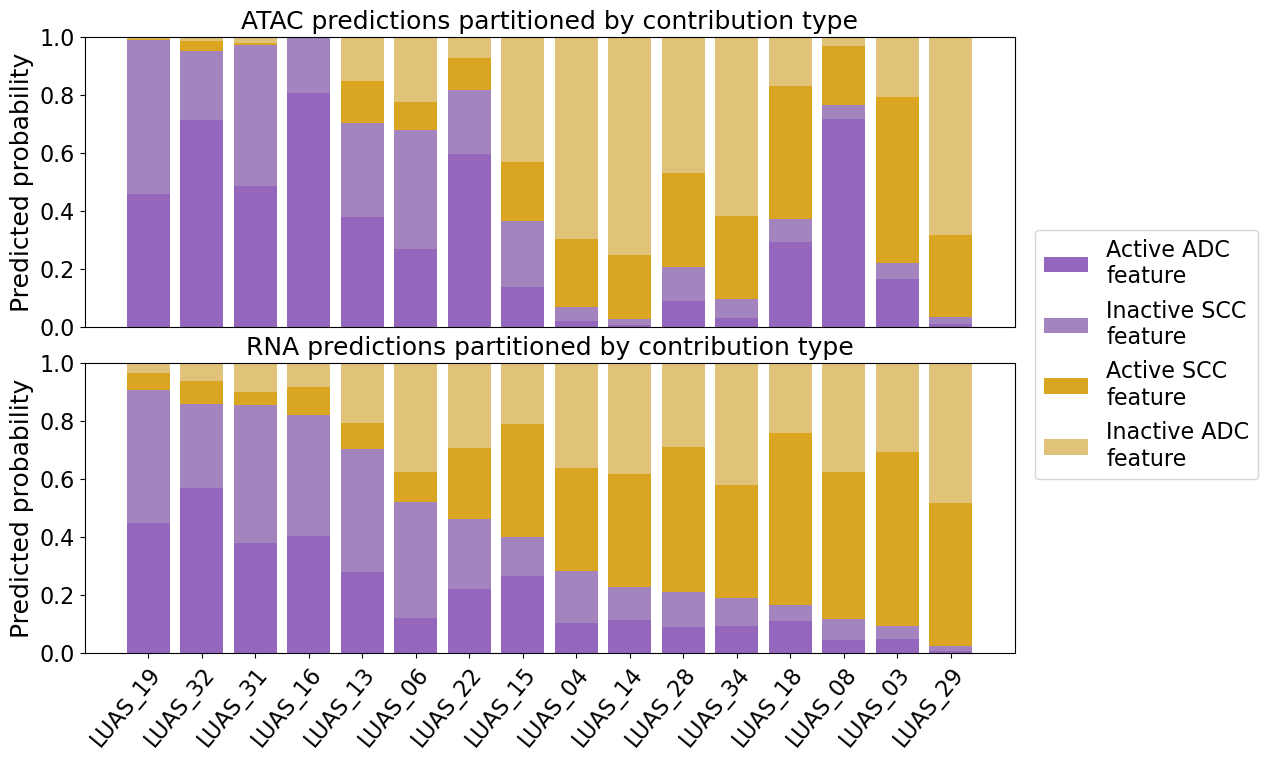

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'hspace': 0.125})
cmapping = {
    'Active ADC': 'C4',
    'Inactive SCC': '#a384bf',
    'Active SCC': 'goldenrod',
    'Inactive ADC': '#e0c379'
}
title_fontsize = 18
atac_title = 'ATAC predictions partitioned by contribution type'
rna_title = 'RNA predictions partitioned by contribution type'
class_labels = ['Active ADC', 'Inactive SCC', 'Active SCC', 'Inactive ADC']

cmapping = {f'{k}\nfeature': v for k, v in cmapping.items()}
class_labels = [f'{k}\nfeature' for k in class_labels]

order = np.argsort(rna_probs)
plot_stacked_probs(atac_partitioned_probs[order], class_labels=class_labels, sample_labels=atac_X.index[order],
                   n_rows=1, figsize=(12, 4), save_path=None, xlabel='', title=atac_title,
                   ax=axes[0], cmapping=cmapping)
axes[0].set_ylabel('Predicted probability', fontsize=18)
axes[0].set_xticks([])
axes[0].get_legend().remove()
axes[0].tick_params(labelsize=16)
axes[0].set_title(axes[0].get_title(), fontsize=title_fontsize)
plot_stacked_probs(rna_partitioned_probs[order], class_labels=class_labels, sample_labels=rna_X.index[order],
                   n_rows=1, figsize=(12, 4), save_path=None, xlabel='', title=rna_title,
                   ax=axes[1], cmapping=cmapping)
axes[1].set_ylabel('Predicted probability', fontsize=18)
axes[1].legend(bbox_to_anchor=(1.01, 1.03), loc="center left", fontsize=16)
axes[1].set_title(axes[1].get_title(), fontsize=title_fontsize)
axes[1].tick_params(labelsize=16)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation_mode='anchor', ha='right', rotation=50)
plt.show()

# Cluster-level

In [30]:
# Load normalized ATAC data
atac_clusterbulks_normed = pyreadr.read_r(f'{atac_modeling_dir}/luas_cluster_log2cpm_jointTMMwsp.rds')[None].T

# Load and normalize RNA data 
compare_vs_gorces_dir = ('/data1/chanj3/LUAS.multiome.results/epigenetic/accessibility_landscape'
                   '/v4/out/compare_vs_gorces')
rna_clusterbulks_raw = np.load(f'{compare_vs_gorces_dir}/rna_pseudobulks_raw.npy')
rna_clusterbulk_genes = pd.read_csv(f'{compare_vs_gorces_dir}/rna_pseudobulk_genes.txt', header=None).iloc[:, 0].values
rna_clusterbulk_labels = pd.read_csv(f'{compare_vs_gorces_dir}/rna_pseudobulk_labels.txt', header=None).iloc[:, 0].values
rna_clusterbulks_raw = pd.DataFrame(rna_clusterbulks_raw, index=rna_clusterbulk_labels, columns=rna_clusterbulk_genes)
rna_clusterbulks_normed = tmm_normalize(rna_clusterbulks_raw.T).T
np.save(f'{compare_vs_gorces_dir}/rna_pseudobulks_normed.npy', rna_clusterbulks_normed)

In [18]:
rna_cluster_X = subset_feats(rna_clusterbulks_normed, rna_model.feature_names_in_)
rna_cluster_probs = rna_model.predict_proba(rna_cluster_X)[:, 1]

atac_cluster_X = subset_feats(atac_clusterbulks_normed, atac_model.feature_names_in_)
atac_cluster_probs = atac_model.predict_proba(atac_cluster_X)[:, 1]

sample_nums = rna_pseudobulks_normed.index.str.split('_').str[1]
sample_num_vec = rna_clusterbulks_normed.index.str.split('_').str[0]

sample_num_to_prob = {a: b for a, b in zip(sample_nums, rna_probs)}
score_tuples = [(sample_num_to_prob[sn], p) for sn, p in zip(sample_num_vec, rna_cluster_probs)]
order = sorted(np.arange(len(score_tuples)), key=lambda i: score_tuples[i])

In [19]:
# compute ATAC shap vals
atac_coef, atac_intercept = atac_model.coef_[0], atac_model.intercept_[0]
le = shap.LinearExplainer((atac_coef, atac_intercept), masker=atac_cluster_X)
atac_cluster_shap_vals = le.shap_values(atac_cluster_X)

# compute RNA shap vals
rna_coef, rna_intercept = rna_model.coef_[0], rna_model.intercept_[0]
le = shap.LinearExplainer((rna_coef, rna_intercept), masker=rna_cluster_X)
rna_cluster_shap_vals = le.shap_values(rna_cluster_X)

atac_partitioned_cluster_probs = partition_probs(atac_cluster_probs, atac_coef, atac_cluster_shap_vals)
rna_partitioned_cluster_probs = partition_probs(rna_cluster_probs, rna_coef, rna_cluster_shap_vals)

/tmp/ipykernel_2826969/4211505951.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_x))  # or any colormap


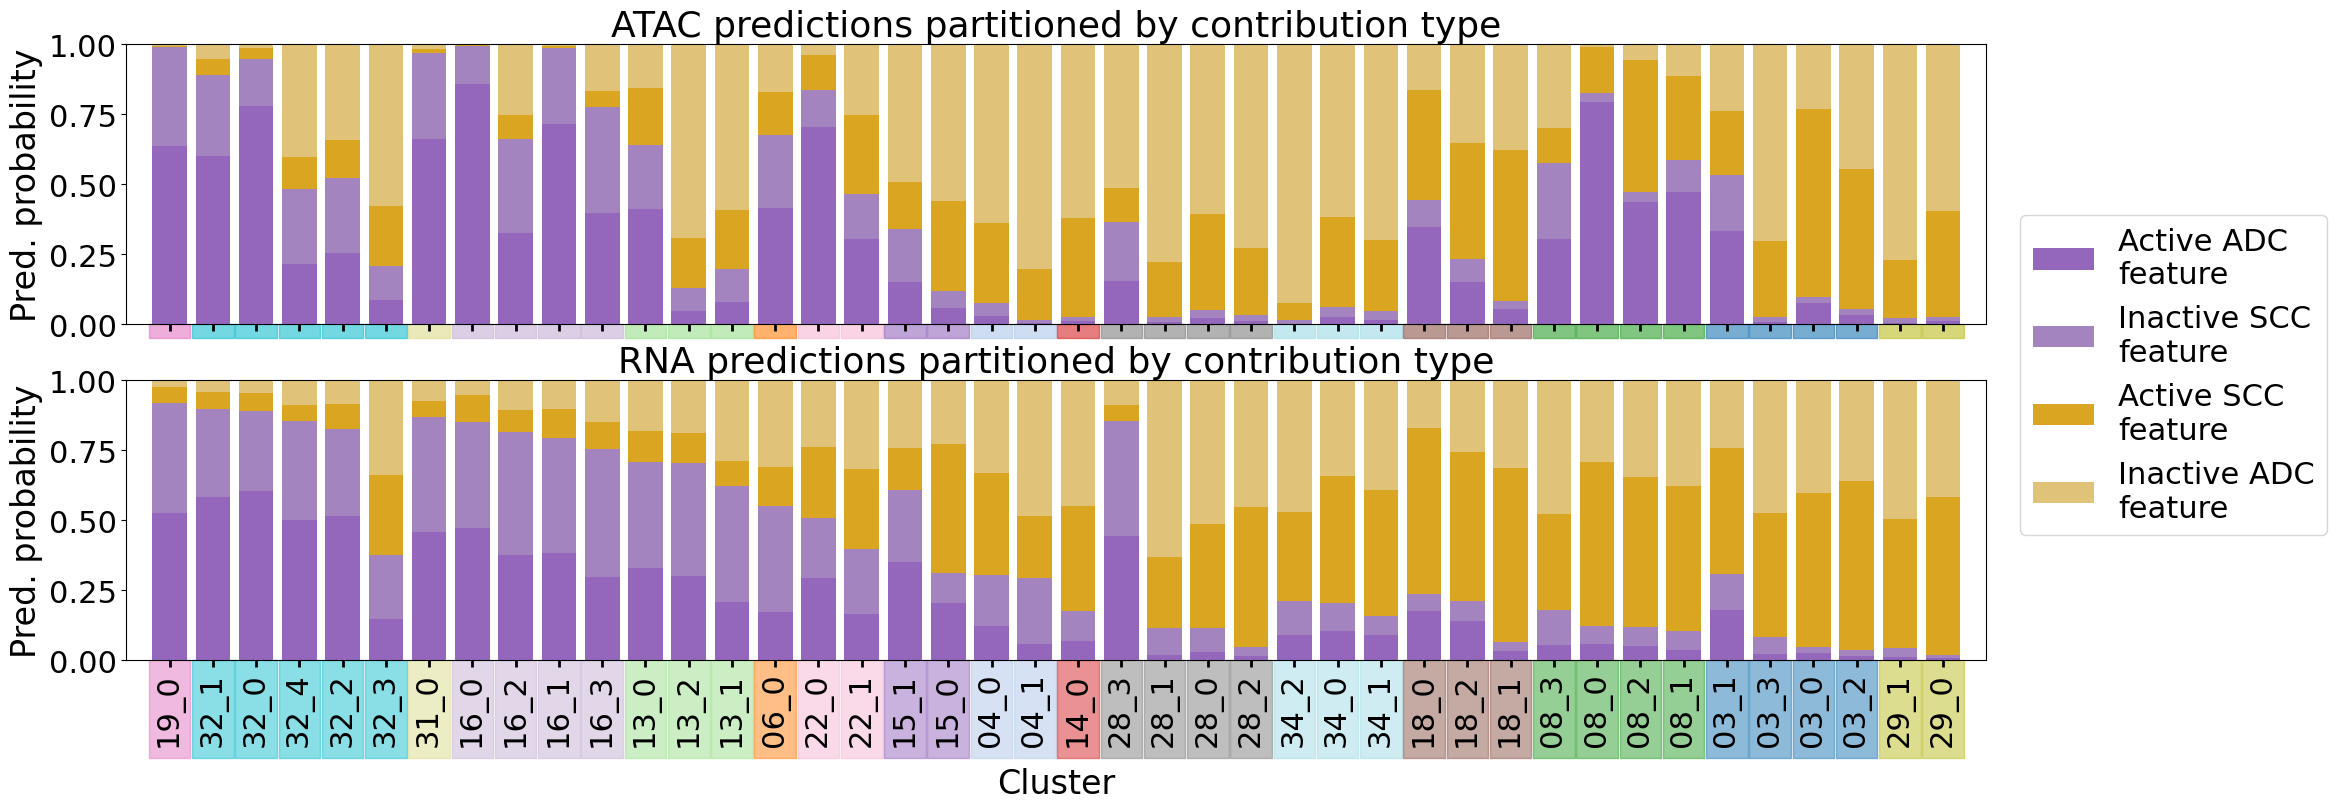

In [20]:
from matplotlib import patches
fig, axes = plt.subplots(2, 1, figsize=(24, 8), gridspec_kw={'hspace': 0.2})
cmapping = {
    'Active ADC': 'C4',
    'Inactive SCC': '#a384bf',
    'Active SCC': 'goldenrod',
    'Inactive ADC': '#e0c379'
}
title_fontsize = 18
atac_title = 'ATAC predictions partitioned by contribution type'
rna_title = 'RNA predictions partitioned by contribution type'
class_labels = ['Active ADC', 'Inactive SCC', 'Active SCC', 'Inactive ADC']

cmapping = {f'{k}\nfeature': v for k, v in cmapping.items()}
class_labels = [f'{k}\nfeature' for k in class_labels]

plot_stacked_probs(atac_partitioned_cluster_probs[order], class_labels=class_labels,
                   sample_labels=atac_clusterbulks_normed.index[order],
                   save_path=None, xlabel='', title=atac_title, ax=axes[0],
                   cmapping=cmapping)
axes[0].set_ylabel('Pred. probability', fontsize=24)
axes[0].set_xticklabels([])
axes[0].get_legend().remove()
axes[0].set_title(axes[0].get_title(), fontsize=26)
plot_stacked_probs(rna_partitioned_cluster_probs[order], class_labels=class_labels,
                   sample_labels=rna_clusterbulks_normed.index[order],
                   save_path=None, xlabel='', title=rna_title, ax=axes[1],
                   cmapping=cmapping)
axes[1].set_title(axes[1].get_title(), fontsize=26)
axes[1].set_ylabel('Pred. probability', fontsize=24)
#axes[1].legend(bbox_to_anchor=(1.008, 2.18), loc="lower right", fontsize=22, ncols=2)
axes[1].legend(bbox_to_anchor=(1.01, 1.02), loc="center left", fontsize=22)
for ax in axes:
    ax.tick_params(axis='both', labelsize=22)
    ax.tick_params(axis='x', size=5, width=2)

# Assign a color per unique 'x'
labels = rna_clusterbulks_normed.index
unique_x = sorted(set(label.split("_")[0] for label in labels))
cmap = plt.cm.get_cmap("tab20", len(unique_x))  # or any colormap
color_map = {x: cmap(i) for i, x in enumerate(unique_x)}

# Shade rectangles behind tick labels
ax0 = axes[0]
ax = axes[1]
ax.figure.canvas.draw()  # need layout info first
xticks = ax.get_xticks()
for tick, label in zip(xticks, ax.get_xticklabels()):
    x_str = label.get_text().split("_")[0]
    color = color_map[x_str]
    # Position: x coordinate in axis coords, y in display units
    bbox = label.get_window_extent(renderer=fig.canvas.get_renderer())
    bbox = bbox.transformed(ax.transData.inverted())  # convert to data coords

    # Rectangle under label
    inflate = 1.34
    x0 = bbox.x0 - (bbox.width)*(inflate - 1) / 2
    rect = patches.Rectangle(
        (x0, -0.35),   # (left, bottom)
        inflate*bbox.width, 0.35,   # (width, height)
        transform=ax.transData,
        color=color,
        alpha=0.5,
        zorder=-1,
        clip_on=False
    )
    ax.add_patch(rect)

    depth = 0.05
    rect = patches.Rectangle(
        (x0, -depth),   # (left, bottom)
        inflate*bbox.width, depth,   # (width, height)
        transform=ax0.transData,
        color=color,
        alpha=0.6,
        zorder=-1,
        clip_on=False
    )
    ax0.add_patch(rect)
axes[1].set_xlabel('Cluster', fontsize=24, labelpad=15)
for ax in axes:
    ax.set_xlim([-1, len(order)])
plt.show()

In [21]:
# save predicted probabilities
pd.Series(
    atac_cluster_probs,
    index=atac_clusterbulks_normed.index
).to_csv(f'{atac_modeling_dir}/atac_cluster_scc_probs.csv')

pd.Series(
    rna_cluster_probs,
    index=rna_clusterbulks_normed.index
).to_csv(f'{compare_vs_gorces_dir}/rna_cluster_scc_probs.csv')

# Metacell-level

In [ ]:
# Load normed ATAC metacells
atac_metacells_normed = pyreadr.read_r(f'{atac_modeling_dir}/metacells_atac_log2cpm_scran.rds')[None].T
atac_metacells_X = subset_feats(atac_metacells_normed, atac_model.feature_names_in_)
atac_metacells_X[atac_metacells_X < 0.1] = 0

# Load normed RNA metacells
rna_metacells_normed = pyreadr.read_r(f'{atac_modeling_dir}/metacells_rna_log2cpm_TMM.rds')[None].T
rna_metacells_X = subset_feats(rna_metacells_normed, rna_model.feature_names_in_)

In [25]:
# Predict on ATAC metacells
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
logit_baseline = 2.9
factor = 1.33
atac_metacells_logits = atac_model.decision_function(atac_metacells_X)
atac_metacells_probs = sigmoid(factor*(atac_metacells_logits - logit_baseline))

# Predict on RNA metacells
rna_metacells_probs = rna_model.predict_proba(rna_metacells_X)[:, 1]

In [27]:
# save predicted probabilities
pd.Series(
    atac_metacells_probs,
    index=atac_metacells_normed.index
).to_csv(f'{atac_modeling_dir}/atac_metacells_scc_probs.csv')

pd.Series(
    rna_metacells_probs,
    index=rna_metacells_normed.index
).to_csv(f'{compare_vs_gorces_dir}/rna_metacells_scc_probs.csv')

print(f'Mean ATAC metacells prediction: {atac_metacells_probs.mean()}')
print(f'Mean RNA metacells prediction: {rna_metacells_probs.mean()}')

Mean ATAC metacells prediction: 0.48545357732370853
Mean RNA metacells prediction: 0.5994036173104254


In [28]:
# compute ATAC shap vals
le = shap.LinearExplainer((atac_coef, atac_intercept), masker=atac_metacells_X)
atac_metacells_shap_vals = le.shap_values(atac_metacells_X)

# compute RNA shap vals
le = shap.LinearExplainer((rna_coef, rna_intercept), masker=rna_metacells_X)
rna_metacells_shap_vals = le.shap_values(rna_metacells_X)

# get metacell-level partitioned probs
atac_partitioned_metacells_probs = partition_probs(
    atac_metacells_probs, atac_coef, atac_metacells_shap_vals 
)
rna_partitioned_metacells_probs = partition_probs(
    rna_metacells_probs, rna_coef, rna_metacells_shap_vals 
)

/tmp/ipykernel_493165/3568739458.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


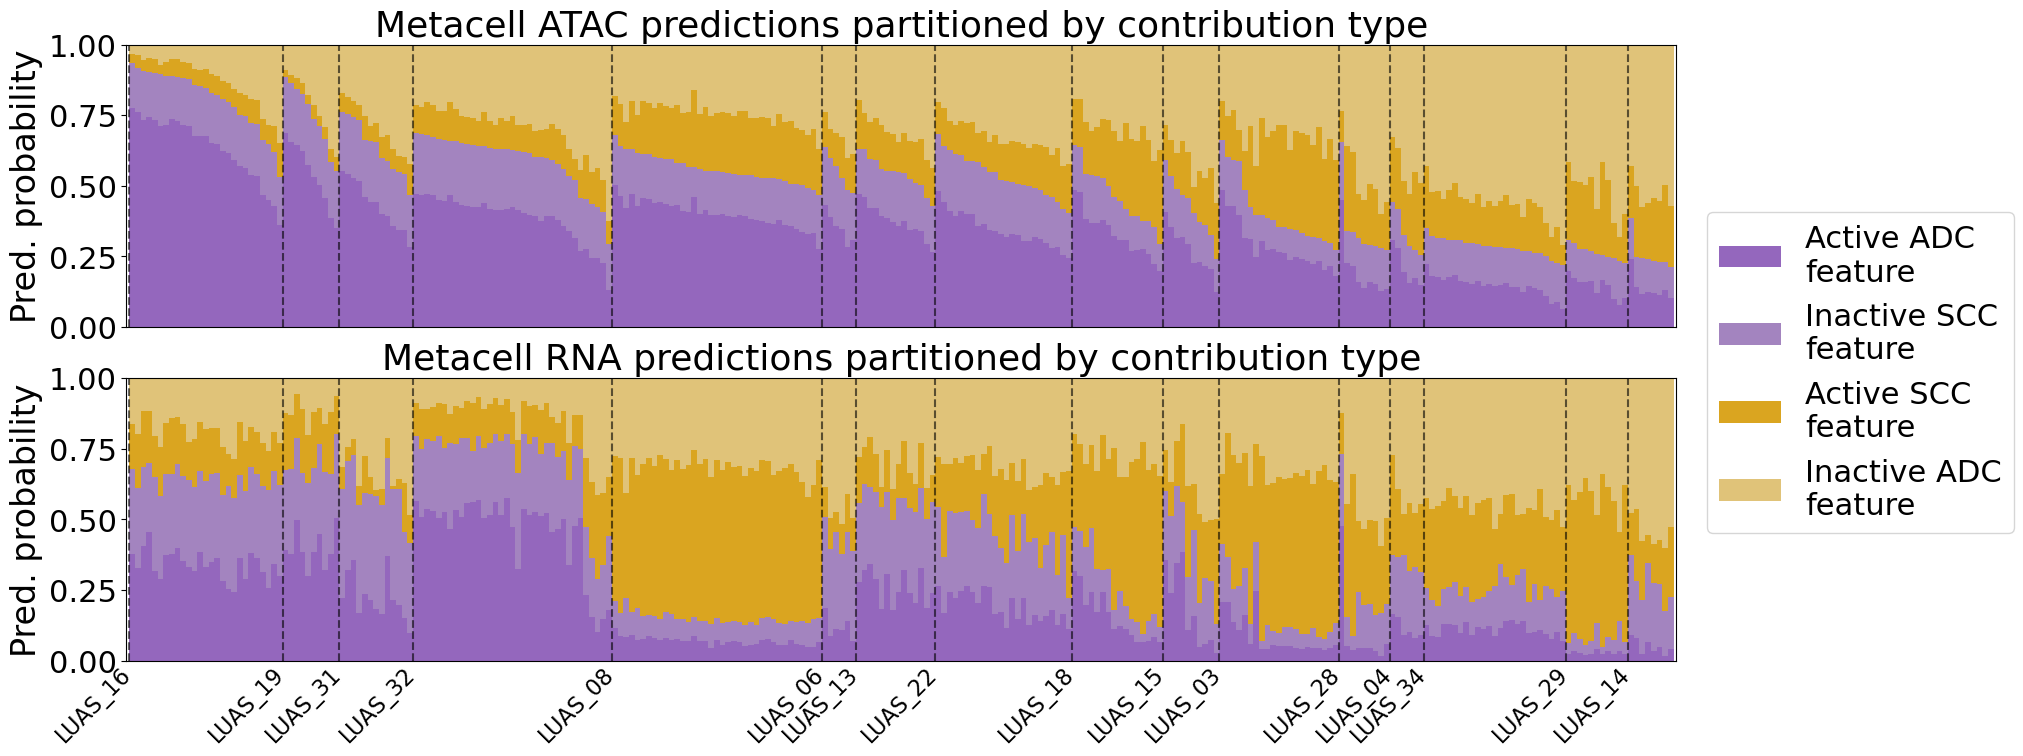

In [53]:
# Get sample and metacell info into a DataFrame
metacells_index = atac_metacells_normed.index
assert np.all(metacells_index == rna_metacells_normed.index)
metacell_data = pd.DataFrame({
    'sample': metacells_index.str.split('---').str[1],
    'metacell': metacells_index.str.split('---').str[0],
    'rna_prob': rna_metacells_probs,
    'atac_prob': atac_metacells_probs
})

sort_by = 'atac_prob'

# Sort samples by mean RNA prob
sample_means = metacell_data.groupby('sample')[sort_by].mean()
sample_order = sample_means.sort_values(ascending=True).index

# Sort metacells within each sample by RNA prob
sorted_data = []
sorted_atac_probs = []
sorted_rna_probs = []
for sample in sample_order:
    mask = metacell_data['sample'] == sample
    sample_data = metacell_data[mask].copy()
    order = sample_data[sort_by].argsort()
    sorted_data.append(sample_data.iloc[order])
    
    # Get indices for the partitioned probabilities
    original_indices = np.where(mask)[0][order]
    sorted_atac_probs.append(atac_partitioned_metacells_probs[original_indices])
    sorted_rna_probs.append(rna_partitioned_metacells_probs[original_indices])

sorted_data = pd.concat(sorted_data)
sorted_atac_probs = np.vstack(sorted_atac_probs)
sorted_rna_probs = np.vstack(sorted_rna_probs)

# Create the plot
fig, axes = plt.subplots(2, 1, figsize=(20, 8), gridspec_kw={'hspace': 0.18}, sharex=True)

# Define colors and labels
cmapping = {
    'Active ADC\nfeature': 'C4',
    'Inactive SCC\nfeature': '#a384bf',
    'Active SCC\nfeature': 'goldenrod',
    'Inactive ADC\nfeature': '#e0c379'
}
class_labels = list(cmapping.keys())
barwidth = 1
# Plot stacked bars
plot_stacked_probs(sorted_atac_probs, class_labels=class_labels,
                   sample_labels=sorted_data.index,
                   save_path=None, xlabel='', 
                   title='Metacell ATAC predictions partitioned by contribution type',
                   ax=axes[0], cmapping=cmapping, width=barwidth)
axes[0].set_ylabel('Pred. probability', fontsize=24)
axes[0].set_xticks([])
axes[0].get_legend().remove()
axes[0].set_title(axes[0].get_title(), fontsize=26)

plot_stacked_probs(sorted_rna_probs, class_labels=class_labels,
                   sample_labels=sorted_data.index,
                   save_path=None, xlabel='',
                   title='Metacell RNA predictions partitioned by contribution type',
                   ax=axes[1], cmapping=cmapping, width=barwidth)
axes[1].set_xticks([])
axes[1].set_title(axes[1].get_title(), fontsize=26)
axes[1].set_ylabel('Pred. probability', fontsize=24)
axes[1].legend(bbox_to_anchor=(1.01, 1.02), loc="center left", fontsize=22)

# Add sample boundaries and labels
prev_sample = None
for i, sample in enumerate(sorted_data['sample']):
    if sample != prev_sample:
        for ax in axes:
            ax.axvline(i-0.5, color='k', linestyle='--', alpha=0.6)
            if ax == axes[1]:
                ax.text(i + 0.03, -0.05, sample, rotation=45, ha='right', fontsize=16, rotation_mode='anchor')
    prev_sample = sample

# Formatting
for ax in axes:
    ax.tick_params(axis='both', labelsize=22)
    ax.set_xlim(-1, len(sorted_data))

plt.tight_layout()
plt.show()